## Otros temas de regresion lineal
Asociado al modelo de regresion lineal existen conceptos adicionales que suelen ser relevantes ser considerados en las estimaciones:
1. Multicolinealidad
2. Variables dummy
3. Pronósticos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf

### Multicolinealidad
Para esto se usara con la base de datos Longley, la cual es conocida por contar con alto nivel de multicolinealidad

In [2]:
X = sm.datasets.longley.load_pandas().exog
X = sm.add_constant(X)
y = sm.datasets.longley.load_pandas().endog # Total Employment

dta = X.join(y)
dta.to_csv("../data/longley.csv")

# Modificaciones
X["lnGNPDEFL"] = np.log(X["GNPDEFL"])
X["lnGNP"] = np.log(X["GNP"])
X["lnUNEMP"] = np.log(X["UNEMP"])
X["lnARMED"] = np.log(X["ARMED"])
X["lnPOP"] = np.log(X["POP"])
y = np.log(y)

# Set final
X = X[["const", "lnGNPDEFL", "lnGNP", "lnUNEMP", "lnARMED", "lnPOP"]]
print(X.head())

   const  lnGNPDEFL      lnGNP   lnUNEMP   lnARMED      lnPOP
0    1.0   4.418841  12.364311  7.764721  7.371489  11.586250
1    1.0   4.483003  12.466227  7.751475  7.283448  11.595721
2    1.0   4.479607  12.460924  8.211211  7.387709  11.606170
3    1.0   4.494239  12.558836  8.117014  7.408531  11.616646
4    1.0   4.566429  12.703737  7.649216  8.038835  11.626924


In [3]:
# Model
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 TOTEMP   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     158.3
Date:                Thu, 09 Feb 2023   Prob (F-statistic):           3.49e-09
Time:                        18:11:36   Log-Likelihood:                 59.589
No. Observations:                  16   AIC:                            -107.2
Df Residuals:                      10   BIC:                            -102.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.6488      2.436      3.551      0.0

c:\Users\user\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


¿Como detectar la multicolinealidad?
1. Presencia de estadisticos t bajos 
2. Estimadores cambian fuertemente al agregar explicativas
3. Estimadores cambian fuertemente al agregar observaciones
4. Signos diferentes a los que esperabamos
5. Calculo de la matriz de correlaciones
6. Calculo del factor de inflacion de varianzas (VIF)

In [4]:
# Test 3
results2 = sm.OLS(y.iloc[:3], X.iloc[:3]).fit()

# Variaciones % al quitar 3 observaciones
variaciones = tuple(
    [i for i in (results2.params - results.params) / results.params * 100]
)

for i in variaciones:
    print(f"Variaciones porcentuales {np.round(i, 1)}%")

Variaciones porcentuales -99.5%
Variaciones porcentuales -136.5%
Variaciones porcentuales -1.6%
Variaciones porcentuales 242.8%
Variaciones porcentuales -928.0%
Variaciones porcentuales -1762.3%


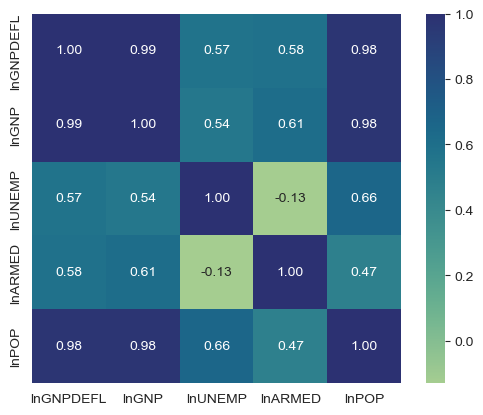

In [5]:
# Test 5
X_corr = X[["lnGNPDEFL", "lnGNP", "lnUNEMP", "lnARMED", "lnPOP"]]
X_corr = X_corr.corr()


plt.figure()
sns.heatmap(
    X_corr, cbar = True, annot = True, square = True,
    fmt = ".2f", annot_kws = {"size":10}, vmax = 1, cmap="crest"
)
plt.subplots_adjust()
plt.savefig("../figures/multicolineality.pdf")

plt.show()

In [6]:
# Test 6
vif = pd.DataFrame()
vif["VIF Factor"] = np.round(
    [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    , 2)
vif["features"] = X.columns
vif.set_index("features", inplace=True)

vif

,VIF Factor
features,
const,1740440.52
lnGNPDEFL,103.05
lnGNP,211.55
lnUNEMP,3.93
lnARMED,4.18
lnPOP,72.71


Gracias a estos dos factores se encuentra que hay presencia de multicolinealidad en las exogenas:
* lnGNPDEFL
* lnGNP
* lnPOP

### Variables dummy
Se puede trabajar con datasets donde la exógena es una dummy binaria o multinominal. Se usara el dataset de la UCLA sobre rendimiento en escritura.

La endogena es `write`. Las exogenas son la dummy `female`, nivel de lectura `read` y la categoria `race` dividido por nivles (1 = Hispanic, 2 = Asian, 3 = African American and 4 = Caucasian)

In [7]:
url = "https://stats.idre.ucla.edu/stat/data/hsb2.csv"
df = pd.read_table(url, delimiter=",")
df.to_csv("../data/ucla.csv")

df.head(3)

,id,female,race,ses,schtyp,prog,read,write,math,science,socst
0,70,0,4,1,1,1,57,52,41,47,57
1,121,1,4,2,1,3,68,59,53,63,61
2,86,0,4,3,1,1,44,33,54,58,31


In [8]:
df = df[["write", "female", "read", "race"]]
df.head(3)

,write,female,read,race
0,52,0,57,4
1,59,1,68,4
2,33,0,44,4


In [9]:
print(
    np.round(
        df.groupby("race")["write"].mean()
        ,2
    )
)

print("Se encuentra que el mayor nivel de lectura se encuentra \
en las personas asiaticas y en causticos. Los hispanicos \
tienen el menor nivel")

race
1    46.46
2    58.00
3    48.20
4    54.06
Name: write, dtype: float64
Se encuentra que el mayor nivel de lectura se encuentra en las personas asiaticas y en causticos. Los hispanicos tienen el menor nivel


#### Modelo equivocado!!

In [10]:
X = df[["female", "read", "race"]]
y = df["write"]

model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                  write   R-squared (uncentered):                   0.979
Model:                            OLS   Adj. R-squared (uncentered):              0.979
Method:                 Least Squares   F-statistic:                              3070.
Date:                Thu, 09 Feb 2023   Prob (F-statistic):                   4.59e-165
Time:                        18:11:37   Log-Likelihood:                         -693.54
No. Observations:                 200   AIC:                                      1393.
Df Residuals:                     197   BIC:                                      1403.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

#### Modelo correcto!!
Por _default_ se define como base a la _dummy_ igual a 1

In [11]:
model = smf.ols("write ~ read + female + C(race)", data=df)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  write   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     34.22
Date:                Thu, 09 Feb 2023   Prob (F-statistic):           5.50e-25
Time:                        18:11:37   Log-Likelihood:                -669.86
No. Observations:                 200   AIC:                             1352.
Df Residuals:                     194   BIC:                             1372.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       19.2918      2.818      6.845   

Aunque se puede definir de manera explicita cual es la base de la _dummy_ == 1

In [12]:
model = smf.ols("write ~ read + female + C(race, Treatment(reference=1))", data=df)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  write   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     34.22
Date:                Thu, 09 Feb 2023   Prob (F-statistic):           5.50e-25
Time:                        18:11:37   Log-Likelihood:                -669.86
No. Observations:                 200   AIC:                             1352.
Df Residuals:                     194   BIC:                             1372.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


### Pronosticos

In [13]:
dta = sm.datasets.webuse("auto")

X = dta[["weight", "headroom"]]
X = sm.add_constant(X)

dta["lnprice"] = np.log(dta["price"])
y = dta["lnprice"]

# Modelo
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                lnprice   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     16.86
Date:                Thu, 09 Feb 2023   Prob (F-statistic):           1.02e-06
Time:                        18:11:38   Log-Likelihood:                -20.837
No. Observations:                  74   AIC:                             47.67
Df Residuals:                      71   BIC:                             54.59
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.9460      0.170     46.752      0.0

In [14]:
to_predict = np.array([1, 3000, 3], dtype="float")

# Proyección del logaritmo del precio
print(results.predict(to_predict))  # Predicción de la mediana
results.get_prediction(to_predict).summary_frame(alpha=0.05) # Predicción de todos los valores relevantes

[8.63376916]


,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,8.633769,0.038078,8.557843,8.709695,7.976613,9.290926


In [15]:
# Proyeccion del precio
print(np.exp(results.predict(to_predict)))

[5618.21437086]


### Referencias:
* https://www.statsmodels.org/dev/datasets/index.html
* https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html
* https://www.statsmodels.org/dev/examples/notebooks/generated/contrasts.html